In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 4.9 MB/s 
     |████████████████████████████████| 1.6 MB 44.2 MB/s 


In [3]:
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [12]:
df_train = pd.read_csv('/content/drive/MyDrive/Redes Neurais/Github/Redes-Neurais/Titanic/train.csv')

#Simplista tirar o NAN

df_train = df_train.dropna()

In [18]:
a = df_train.drop(columns = ['PassengerId', 'Name', 'Cabin']).head(3000)

In [19]:
a = pd.get_dummies(a, columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'])

In [21]:
a.to_csv('Dados_2.csv')

### Tratar a base

In [5]:
df_train.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [6]:
y = df_train[['Transported']]
y['Transported'] = y['Transported'].apply(lambda x: 1 if x == True else 0)

train = df_train.drop(columns = ['PassengerId', 'Name', 'Transported'])

## Dummie dos categóricos (testar sem dummies fazendo os encoders dentro da coluna)

train = pd.concat((train, pd.get_dummies(train[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']])), axis=1)
train = train.drop(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
## Parte de tratamento das cabines. Pode ignorar

train = train.drop(train['Cabin'][train['Cabin'] == 'NoneCabin'].index, axis=0)
train['Cabin'] = train['Cabin'].fillna(train['Cabin'].mode()[0])

first, sec, thrd = [], [], []
mem = []
for i in range(train['Cabin'].shape[0]):
    mem = train['Cabin'].iloc[i].split('/')
    first.append(mem[0])
    sec.append(mem[1])
    thrd.append(mem[2])
first = pd.Series(first)
first.index = train['Cabin'].index
sec = pd.Series(sec)
sec.index = train['Cabin'].index
thrd = pd.Series(thrd) 
thrd.index = train['Cabin'].index
train['CabinClass'] = first
train['CabinNumber'] = sec
train['CabinSeat'] = thrd

'''first, sec, thrd = [], [], []
mem = []
for i in range(test['Cabin'].shape[0]):
    mem = test['Cabin'].iloc[i].split('/')
    first.append(mem[0])
    sec.append(mem[1])
    thrd.append(mem[2])
first = pd.Series(first)
first.index = test['Cabin'].index
sec = pd.Series(sec)
sec.index = test['Cabin'].index
thrd = pd.Series(thrd) 
thrd.index = test['Cabin'].index
test['CabinClass'] = first
test['CabinNumber'] = sec
test['CabinSeat'] = thrd'''

train = train.drop('Cabin',axis=1)
'''test = test.drop('Cabin',axis=1)

test.dtypes[(test.dtypes == "object") == True].index.tolist()

test.dtypes[(test.dtypes != "object") == True].index.tolist() == train.dtypes[(train.dtypes != "object") == True].index.tolist()
'''
train = pd.concat((train, pd.get_dummies(train['CabinClass'])), axis=1)
train = pd.concat((train, pd.get_dummies(train['CabinSeat'])), axis=1)
train = train.drop(['CabinClass','CabinSeat'],axis=1)

In [8]:
### Normalizar

transformer = Normalizer().fit(train) 
transformer
train=transformer.transform(train)


'''#Splitar em treinamento e teste

x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.3)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)'''

x_train = train
y_train = y

###Estrutura da rede

In [9]:
def model_builder(hp):
  model = Sequential() 
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_units, activation='relu', input_dim=train.shape[1]))
  model.add(Dense(units=hp_units, activation='relu', input_dim=train.shape[1]))
  model.add(Dense(units=hp_units, activation='relu', input_dim=train.shape[1]))
  model.add(Dense(units=hp_units, activation='relu', input_dim=train.shape[1]))
  model.add(Dense(units=hp_units, activation='relu', input_dim=train.shape[1]))
  model.add(Dense(units=hp_units, activation='relu', input_dim=train.shape[1]))
  
  drop_units = hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)
  model.add(Dropout(drop_units))
  model.add(Dense(1, activation='sigmoid')) 

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
  
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir_8',
                     project_name='intro_to_kt')

In [10]:
tuner = kt.BayesianOptimization(model_builder,
                     max_trials =10,
                     objective='val_accuracy',
                     directory='my_dir_10')

In [11]:
tuner.search(x_train, y_train, epochs=100, validation_split=0.3)

Trial 10 Complete [00h 06m 23s]
val_accuracy: 0.8107971549034119

Best val_accuracy So Far: 0.8118062615394592
Total elapsed time: 00h 53m 21s


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. Dropout: {best_hps.get('dropout')}
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.01. Dropout: 0.30000000000000004



In [ ]:
tuner.get_best_models()[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=200, validation_split=0.2)

Epoch 1/50
166/166 [==============================] - 2s 11ms/step - loss: 0.5749 - accuracy: 0.7557 - val_loss: 0.6274 - val_accuracy: 0.6316
Epoch 2/50
166/166 [==============================] - 2s 10ms/step - loss: 0.5126 - accuracy: 0.7861 - val_loss: 0.6290 - val_accuracy: 0.6755
Epoch 3/50
166/166 [==============================] - 2s 10ms/step - loss: 0.4853 - accuracy: 0.7877 - val_loss: 0.4941 - val_accuracy: 0.7973
Epoch 4/50
166/166 [==============================] - 2s 10ms/step - loss: 0.4982 - accuracy: 0.7863 - val_loss: 0.4952 - val_accuracy: 0.8056
Epoch 5/50
166/166 [==============================] - 2s 10ms/step - loss: 0.4971 - accuracy: 0.7827 - val_loss: 0.6496 - val_accuracy: 0.5756
Epoch 6/50
166/166 [==============================] - 2s 10ms/step - loss: 0.5113 - accuracy: 0.7786 - val_loss: 0.4868 - val_accuracy: 0.8056
Epoch 7/50
166/166 [==============================] - 2s 10ms/step - loss: 0.4735 - accuracy: 0.7969 - val_loss: 0.4646 - val_accuracy: 0.8056

[]

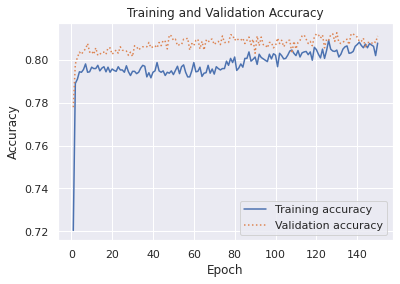

In [ ]:
sns.set()
 
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()